# Spotify Data Analysis: Song Popularity Predictions.

The objective of this notebook is to predict the popularity of a song using a 600k song dataset from Kaggle:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

We will use a mix of categorical and numerical features from 'tracks.csv' to perform a multi-linear regression using Scikit-Learn Pipelines. The objective is to minimize the "mean_absolute_error" metric.

In [47]:
import numpy as np
import pandas as pd
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import set_config
from sklearn.metrics import mean_absolute_error

#####
import pandas_profiling as pf
from yellowbrick.regressor import PredictionError

In [2]:
df = pd.read_csv('Dataset/tracks.csv')

The dataset has 20 features (numerical and categorical) and has nearly 600 000 songs.

In [3]:
df.shape

(586672, 20)

In [4]:
df.head(10)

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.744000,0.1510,0.1270,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.000000,0.1480,0.6550,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.021800,0.2120,0.4570,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918000,0.1040,0.3970,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.130000,0.3110,0.1960,103.220,4
5,0BRXJHRNGQ3W4v9frnSfhu,Ave Maria,0,178933,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.227,0.2610,5,-12.343,1,0.0382,0.994,0.247000,0.0977,0.0539,118.891,4
6,0Dd9ImXtAtGwsmsAD69KZT,La Butte Rouge,0,134467,0,['Francis Marty'],['2nuMRGzeJ5jJEKlfS7rZ0W'],1922,0.510,0.3550,4,-12.833,1,0.1240,0.965,0.000000,0.1550,0.7270,85.754,5
7,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,['Mistinguett'],['4AxgXfD7ISvJSTObqm4aIE'],1922,0.563,0.1840,4,-13.757,1,0.0512,0.993,0.000016,0.3250,0.6540,133.088,3
8,0IgI1UCz84pYeVetnl1lGP,Old Fashioned Girl,0,310073,0,['Greg Fieler'],['5nWlsH5RDgFuRAiDeOFVmf'],1922,0.488,0.4750,0,-16.222,0,0.0399,0.620,0.006450,0.1070,0.5440,139.952,4
9,0JV4iqw2lSKJaHBQZ0e5zK,Martín Fierro - Remasterizado,0,181173,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-29,0.548,0.0391,6,-23.228,1,0.1530,0.996,0.933000,0.1480,0.6120,75.595,3


In [5]:
df.dtypes

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit              int64
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object

Let's select a random subset:

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

Let's check for Nan values. 'name' is the only column with Nan values and it will be dropped later on as it is of no use for our model:

In [7]:
df.isna().sum()

id                   0
name                71
popularity           0
duration_ms          0
explicit             0
artists              0
id_artists           0
release_date         0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
time_signature       0
dtype: int64

The 'popularity' column is our numerical target value, let's visualize its distribution with 100 bins (ratings from 0 - 100):

<AxesSubplot:ylabel='Frequency'>

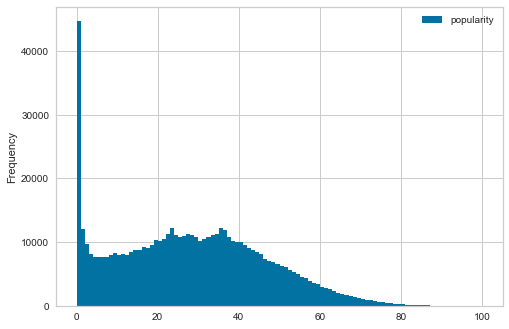

In [8]:
df[['popularity']].plot.hist(bins=100)

It seems like a significant amount of songs were not rated, or very rarely/poorly rated (no information about rating methods was provided). Consequently, our distribution appears to be skewed by these outliers. in order to preserve a more Gaussian-like distribution, let's get rid of them so we can learn relevant patterns from the rest of our data:

In [9]:
df.drop(df[df['popularity']<5].index, inplace=True)

<AxesSubplot:ylabel='Frequency'>

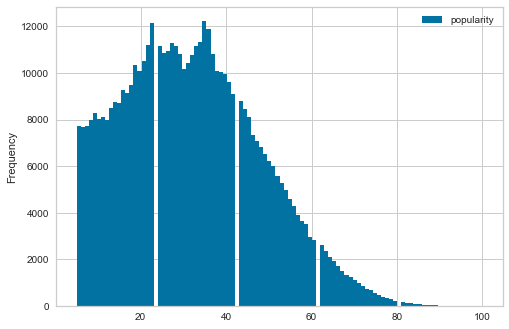

In [10]:
df[['popularity']].plot.hist(bins=100)

In [11]:
df.shape

(504432, 20)

Now let's define our X input matrix and y target vector:

In [12]:
X = df[['explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']]
X.describe()

,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000,504432.000000
mean,0.049386,0.570344,0.566576,5.226804,-9.779920,0.654560,0.099734,0.407362,0.084373,0.212778,0.557935,119.248265,3.885782
std,0.216673,0.163639,0.241947,3.525833,4.802048,0.475512,0.170231,0.328879,0.231377,0.185540,0.255223,29.526877,0.445371
min,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.462000,0.387000,2.000000,-12.333000,0.000000,0.033400,0.083600,0.000000,0.096800,0.353000,96.283000,4.000000
50%,0.000000,0.583000,0.578000,5.000000,-8.883000,1.000000,0.043200,0.359000,0.000012,0.137000,0.569000,118.043000,4.000000
75%,0.000000,0.690000,0.763000,8.000000,-6.295000,1.000000,0.073800,0.710000,0.002970,0.276000,0.773000,137.316000,4.000000
max,1.000000,0.991000,1.000000,11.000000,4.584000,1.000000,0.971000,0.996000,1.000000,1.000000,1.000000,246.381000,5.000000


In [34]:
y = df.popularity.values

Now let's cast the categorical columns type as 'category' and then make use of the sklearn selector method to create one list of numerical columns and one list of categorical columns:

In [14]:
X.loc[:, ['explicit', 'key', 'mode', 'time_signature']] = X.loc[:, ['explicit', 'key', 'mode', 'time_signature']].astype('category')

/Users/msf/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [15]:
numerical_columns_selector = selector(dtype_exclude='category')
categorical_columns_selector = selector(dtype_include='category')

numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)

In [16]:
numerical_columns

['danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [17]:
categorical_columns

['explicit', 'key', 'mode', 'time_signature']

In [18]:
X.dtypes

explicit            category
danceability         float64
energy               float64
key                 category
loudness             float64
mode                category
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
time_signature      category
dtype: object

Now let's define the transformers (preprocessors) for our sklearn pipeline: OneHotEncoder for categorical columns and StandardScaler for numerical columns. 

In [19]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
numerical_preprocessor = StandardScaler()

In [20]:
preprocessor = ColumnTransformer([
    ('One-Hot-Encoder', categorical_preprocessor, categorical_columns),
    ('Standard-Scaler', numerical_preprocessor, numerical_columns)])

Let's define our model (default number of iteration for training = 1000) and let's visualize our pipeline architecture:

In [21]:
model = make_pipeline(preprocessor, LinearRegression())
set_config(display='diagram')
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('One-Hot-Encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['explicit', 'key', 'mode',
                                                   'time_signature']),
                                                 ('Standard-Scaler',
                                                  StandardScaler(),
                                                  ['danceability', 'energy',
                                                   'loudness', 'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo'])])),
                ('linearregression', LinearRegression())])

Let's split the data into train and test sets with a 80/20 ratio:

In [22]:
data_train, data_test, target_train, target_test = train_test_split(X, y, test_size=0.4)

Training the model:

In [23]:
_ = model.fit(data_train, target_train)

Predictions and performance metrics:

In [24]:
pred_test = model.predict(data_test)

In [25]:
mean_absolute_error(target_test, pred_test)

11.837502136576825

In [26]:
pred_train = model.predict(data_train)

In [27]:
mean_absolute_error(target_train, pred_train)

11.82909534643619

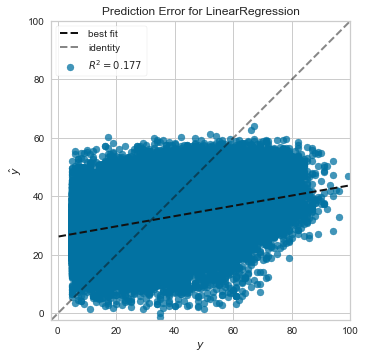

<AxesSubplot:title={'center':'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [28]:
visualizer = PredictionError(model)
visualizer.fit(data_train, target_train)
visualizer.score(data_test, target_test)
visualizer.show()

In [29]:
err = abs(target_test - pred_test)

In [30]:
error = pd.DataFrame(err, columns = ['error'])

<AxesSubplot:ylabel='Frequency'>

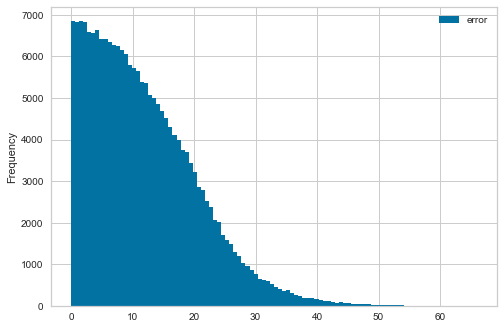

In [31]:
error.plot.hist(bins=100)

In [32]:
error.describe()

,error
count,201773.000000
mean,11.837502
std,8.577730
min,0.000000
25%,4.959473
50%,10.353271
75%,17.113525
max,65.958374
